#### TopN Simple Wines Recommender System From A User Code With Tensorflow
#### Rogério Xavier de Azambuja (rogerio.xavier@farroupilha.ifrs.edu.br)
#### Dataset X-Wines from https://github.com/rogerioxavier/X-Wines

In [1]:
# Opening required packages for processing
import pandas as pd
import numpy as np
from typing import Dict, Text
import tensorflow as tf
import tensorflow_recommenders as tfrs
# Opening required packages to show output
from matplotlib import pyplot as plt
import cv2 as cv

In [2]:
# Opening X-Wines dataset
wines   = pd.read_csv("XWines_100K.csv", low_memory=False, encoding="utf-8", memory_map=True)
ratings = pd.read_csv("XWines_ratings_21M.csv", low_memory=False, encoding="utf-8", memory_map=True)
len(wines), len(ratings)

(100646, 21013536)

In [3]:
print("Total wines:", wines.WineID.nunique(), "from", wines.Code.nunique() ,"different countries")
print("Total users:", ratings.UserID.nunique(), "who rated the wines in", ratings.Language.nunique() ,"different languages")
print(f"             in the period between {ratings.Date.min()} and {ratings.Date.max()}")
print("Total ratings:", len(ratings), f"5-stars on wine vintages since {ratings.Vintage.min()}, including non-vintage 'N.V.'")

Total wines: 100646 from 60 different countries
Total users: 1056079 who rated the wines in 63 different languages
             in the period between 2012-01-03T08:20:53Z and 2021-12-31T23:59:56Z
Total ratings: 21013536 5-stars on wine vintages since 1950, including non-vintage 'N.V.'


In [4]:
# A first segmentation because the dataset is too big
code = 'BR'
country = 'Brazil'
language = 'en'  # English language ratings on Brazilian wines   

In [5]:
winesCode = wines.loc[ wines.Code==code ]
print(winesCode.WineID.nunique(), f"wines from the country {country}({code}) ")

1556 wines from the country Brazil(BR) 


In [6]:
ratingsLang = ratings.loc[ ratings.Language==language ]
print(ratingsLang.UserID.nunique(), f"users for {language} language")
print(len(ratingsLang), f"ratings for {language} language")

572458 users for en language
10157660 ratings for en language


In [7]:
# Data preparation for wine recommendation
ratingsLang = ratingsLang.sort_values(['Date'], ascending=False)
ratingsLang = ratingsLang.drop_duplicates(subset=['UserID', 'WineID'], keep='first')
ratingsLang = pd.merge(ratingsLang, winesCode.WineID, how="inner", on=['WineID'])
print(len(ratingsLang), f"unique last ratings from {language} language's users about {code} wines")

21688 unique last ratings from en language's users about BR wines


In [8]:
# Cut-off point for training on the most relevant data
mostRatingsWines = ratingsLang.groupby(['WineID'], as_index=False)['Rating'].count()
mostRatingsWines.rename(columns={'Rating':'Frequency'}, inplace=True)
mostRatingsWines = mostRatingsWines.loc[ mostRatingsWines.Frequency>0 ] # optional minimum value
print(len(mostRatingsWines), "most ratings wines")

mostRatingsUsers = ratingsLang.groupby('UserID', as_index=False)['Rating'].count()
mostRatingsUsers.rename(columns={'Rating':'Frequency'}, inplace=True)
mostRatingsUsers = mostRatingsUsers.loc[ mostRatingsUsers.Frequency>0 ]  # optional minimum value
print(len(mostRatingsUsers), "most ratings users")

1283 most ratings wines
9236 most ratings users


In [9]:
# Data segmentation for collaborative filtering
collabRatings = pd.merge(ratingsLang,  mostRatingsWines.WineID, how="inner", on=['WineID'])
print(collabRatings.WineID.nunique(), "most ratings wines")
collabRatings = pd.merge(collabRatings, mostRatingsUsers.UserID, how="inner", on=['UserID'])
print(collabRatings.UserID.nunique(), "most ratings users")

collabWines = pd.merge(mostRatingsWines, winesCode[['WineID', 'WineName']], on='WineID')
collabWines = collabWines[['WineID', 'WineName']].reset_index(drop=True)
collabRatings = collabRatings[['UserID', 'WineID']].reset_index(drop=True)
print(len(winesCode),'to', len(collabWines), 'useful wines for collaborative filtering')
print(len(ratingsLang),'to', len(collabRatings), 'useful ratings for collaborative filtering')

1283 most ratings wines
9236 most ratings users
1556 to 1283 useful wines for collaborative filtering
21688 to 21688 useful ratings for collaborative filtering


In [10]:
# Runtime variables
seed = 42
test_percentage  = 20
train_percentage = 100-test_percentage
embedding_dimension = 32 # 64 ?
metrics_batchsize =  16 * 5 # size x velocit training ?
train_batchsize   = 128 * 5
test_batchsize    =  64 * 5
learning_rate = 0.1 # 0.5 ?
epochs = 5
index_batchsize = 100

In [11]:
# Data preparation for machine learning
collabRatings = collabRatings[['UserID','WineID']]
unique_users_ids = collabRatings['UserID'].unique()
unique_wines_ids = collabRatings['WineID'].unique()

view_size  = len(collabRatings)
train_size = round(view_size/100*train_percentage)
test_size  = view_size-train_size

print("Data sample size:", view_size, "   Relationship training/testing:", train_size, test_size)

Data sample size: 21688    Relationship training/testing: 17350 4338


In [12]:
# Tensors using tensorflow
tfRatings = tf.data.Dataset.from_tensor_slices(dict(collabRatings))
tfWines   = tf.data.Dataset.from_tensor_slices(unique_wines_ids)

In [13]:
# Data separation for training and testing model 
tf.random.set_seed(seed)

tfRatings_shuffled = tfRatings.shuffle(view_size, seed=seed, reshuffle_each_iteration=False)

train = tfRatings_shuffled.take(train_size)
test  = tfRatings_shuffled.skip(train_size).take(test_size)

len(train), len(test)

(17350, 4338)

In [14]:
# Simple model layers definition
user_model = tf.keras.Sequential([
  tf.keras.layers.IntegerLookup(vocabulary=unique_users_ids, mask_token=None),
  tf.keras.layers.Embedding(input_dim=len(unique_users_ids) + 1, output_dim=embedding_dimension)
])

wine_model = tf.keras.Sequential([
  tf.keras.layers.IntegerLookup(vocabulary=unique_wines_ids, mask_token=None),
  tf.keras.layers.Embedding(input_dim=len(unique_wines_ids) + 1, output_dim=embedding_dimension)
])

metrics = tfrs.metrics.FactorizedTopK(
  candidates=tfWines.batch(metrics_batchsize).map(wine_model)
)

task = tfrs.tasks.Retrieval(
  metrics=metrics
)

In [15]:
class XWines_Model(tfrs.Model):

    def __init__(self, user_model, wine_model):
        super().__init__()
        self.wine_model: tf.keras.Model = wine_model
        self.user_model: tf.keras.Model = user_model
        self.task: tf.keras.layers.Layer = task

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        wine_embeddings = self.wine_model(features["WineID"])
        user_embeddings = self.user_model(features["UserID"])
        return self.task(user_embeddings, wine_embeddings)

In [16]:
# XWines model building using basic parameters
model = XWines_Model(user_model, wine_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=learning_rate))

Epoch 1/5
28/28 [==============================] - 5s 79ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0081 - factorized_top_k/top_10_categorical_accuracy: 0.0173 - factorized_top_k/top_50_categorical_accuracy: 0.0759 - factorized_top_k/top_100_categorical_accuracy: 0.1271 - loss: 3870.3211 - regularization_loss: 0.0000e+00 - total_loss: 3870.3211
Epoch 2/5
28/28 [==============================] - 2s 78ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0022 - factorized_top_k/top_5_categorical_accuracy: 0.2081 - factorized_top_k/top_10_categorical_accuracy: 0.2861 - factorized_top_k/top_50_categorical_accuracy: 0.5146 - factorized_top_k/top_100_categorical_accuracy: 0.6349 - loss: 3813.9995 - regularization_loss: 0.0000e+00 - total_loss: 3813.9995
Epoch 3/5
28/28 [==============================] - 2s 77ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0052 - factorized_top_k/top_5_categorical_accuracy: 0.4

<AxesSubplot:xlabel='epochs'>

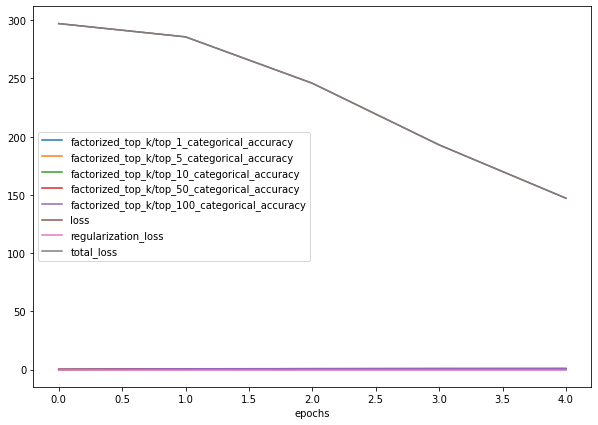

In [17]:
# network training using basic parameters
cached_train = train.shuffle(view_size).batch(train_batchsize).cache()

history = model.fit(cached_train, epochs=epochs)

# plot model training
pd.DataFrame(history.history).plot(figsize=(10,7), xlabel="epochs")

In [18]:
# model testing using basic parameters
cached_test = test.batch(test_batchsize).cache()

model.evaluate(cached_test, return_dict=True)

14/14 [==============================] - 1s 66ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0014 - factorized_top_k/top_5_categorical_accuracy: 0.0164 - factorized_top_k/top_10_categorical_accuracy: 0.0314 - factorized_top_k/top_50_categorical_accuracy: 0.1266 - factorized_top_k/top_100_categorical_accuracy: 0.2036 - loss: 1839.9768 - regularization_loss: 0.0000e+00 - total_loss: 1839.9768


{'factorized_top_k/top_1_categorical_accuracy': 0.0013831258984282613,
 'factorized_top_k/top_5_categorical_accuracy': 0.0163669902831316,
 'factorized_top_k/top_10_categorical_accuracy': 0.03135085478425026,
 'factorized_top_k/top_50_categorical_accuracy': 0.12655602395534515,
 'factorized_top_k/top_100_categorical_accuracy': 0.20355002582073212,
 'loss': 995.839111328125,
 'regularization_loss': 0,
 'total_loss': 995.839111328125}

In [19]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# recommends wines out of the entire wines dataset.
index.index_from_dataset(
    tf.data.Dataset.zip((tfWines.batch(index_batchsize),
    tfWines.batch(index_batchsize).map(model.wine_model)))
)

In [20]:
# TopN simple wines recommender from a user position
def recommenderTF(nUser=0, nRecommendation=10):
    if nUser <= 0:
        print("Bad input to find wines")
        return (pd.DataFrame())
    else:
        scores, winesIDs = index(tf.constant([nUser]))
        print(f"Recommendations for user {nUser}:")
        recList = []
        for (s, n) in zip(scores[0][:nRecommendation], winesIDs[0][:nRecommendation]):
            wineID = int(tf.get_static_value(n))
            wine = winesCode.loc[ winesCode.WineID == wineID ][['WineID', 'WineName']].values[0]
            recList.append({'WineID':wine[0], 'WineName':wine[1], 'Similarity':round( tf.get_static_value(s), 5)})
        recList.sort(key=lambda i: i['Similarity'], reverse=True)
        return (pd.DataFrame(recList))

def show10wines(df=pd.DataFrame()):
    if len(df) == 0:
        print("Bad input to show wines")
        return 
    else:
        if len(df)==1:
            plt.figure(figsize=(25, 10))
        else:
            plt.figure(figsize=(50, 20))
        i = 1
        for (wineID, wineName) in (zip(df.WineID[:10], df.WineName[:10])):
            plt.subplot(2,5,i), plt.imshow( cv.imread(f"images/{wineID}.jpeg",1) )
            plt.title("\n"+wineName, fontsize=35)
            plt.xticks([]),plt.yticks([])
            i+=1
        plt.show()       
        return

Recommendations for user 58:


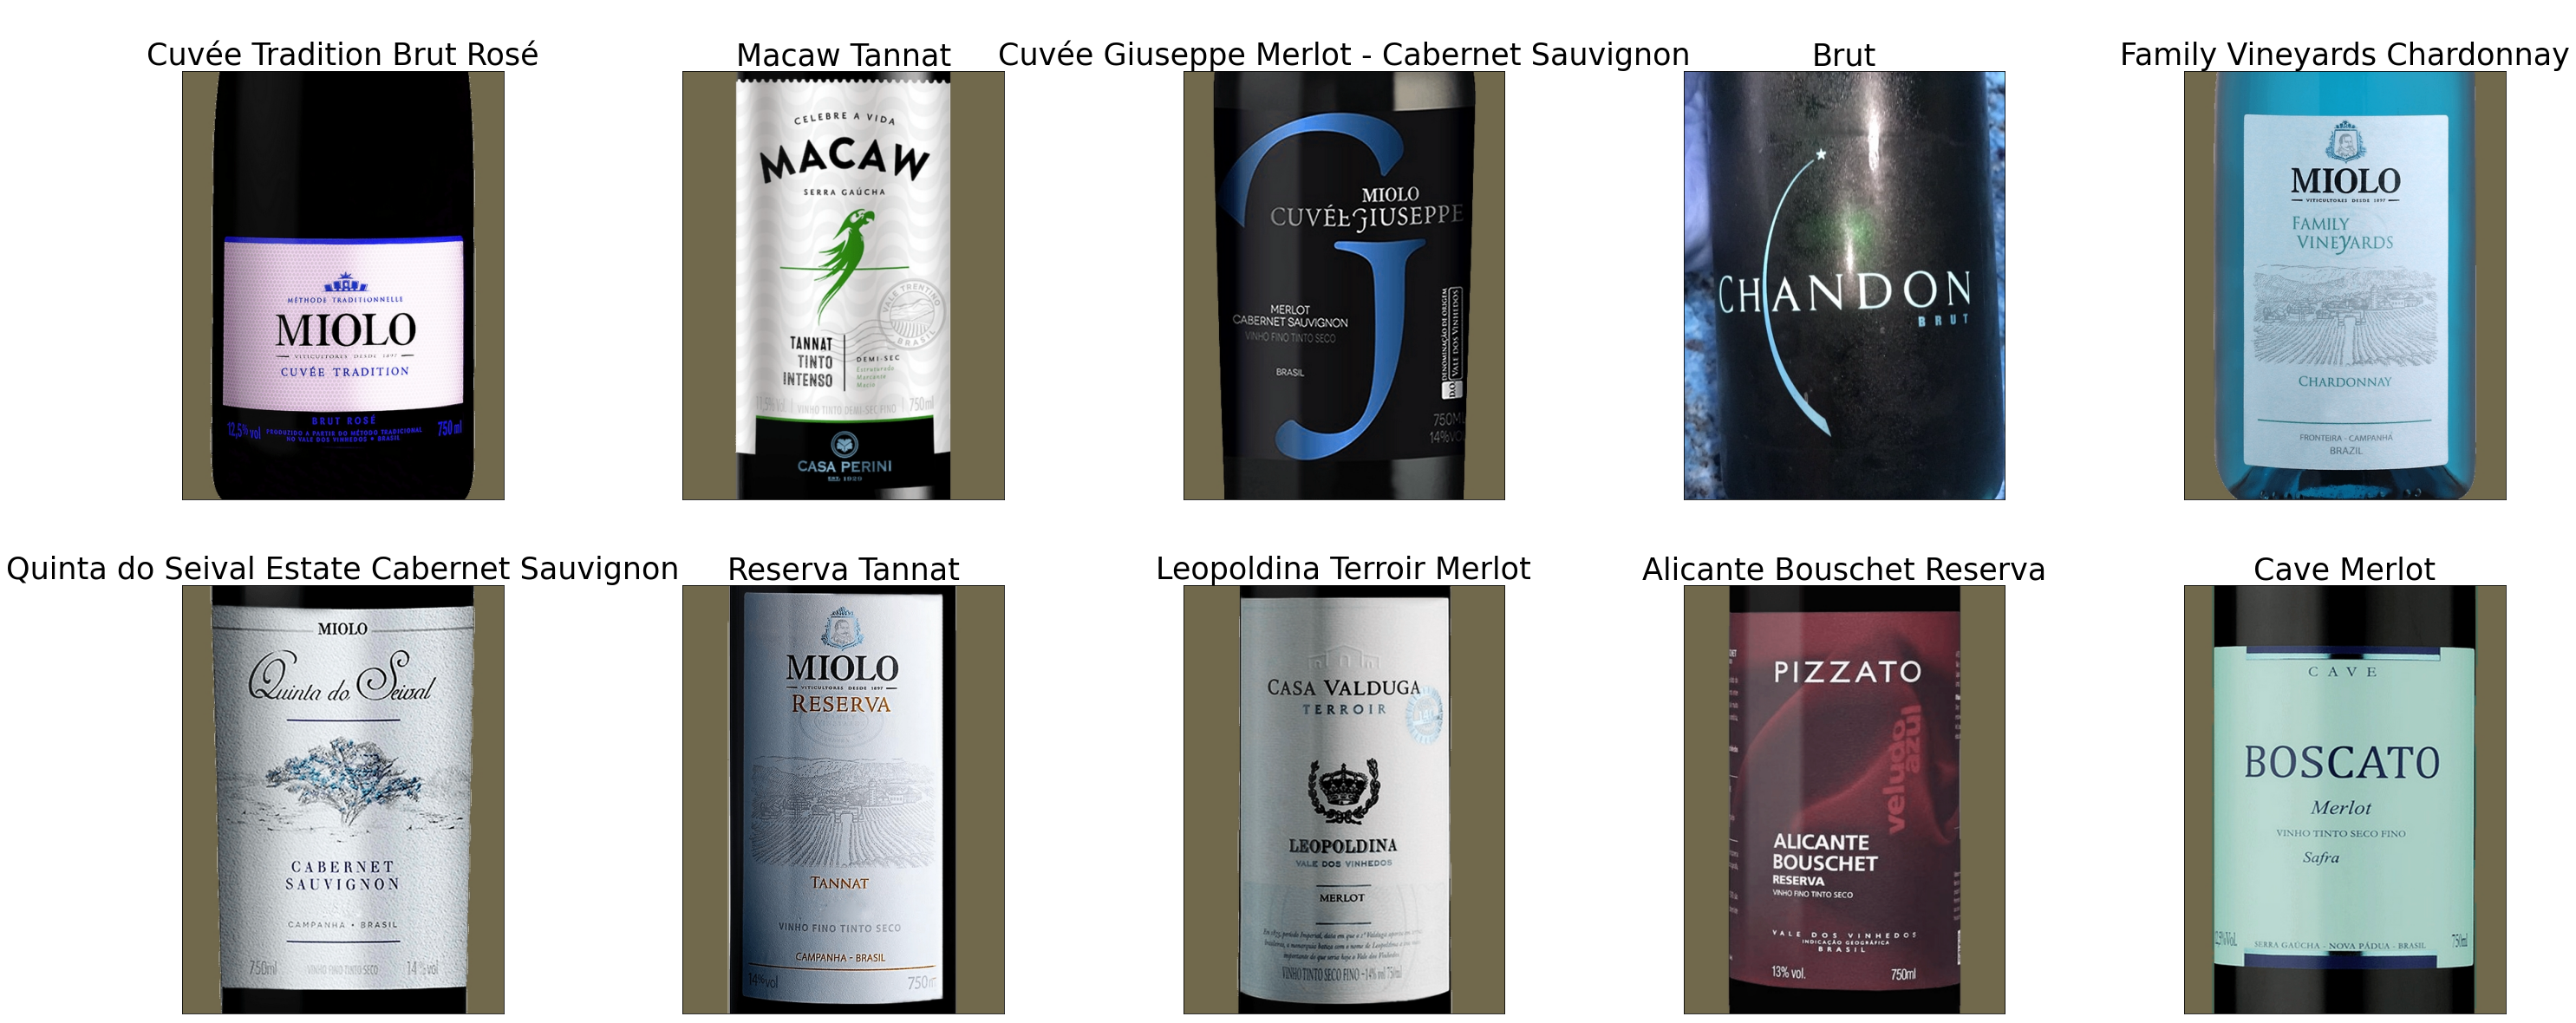

,WineID,WineName,Similarity
0,100169,Cuvée Tradition Brut Rosé,0.39389
1,100439,Macaw Tannat,0.37771
2,100049,Cuvée Giuseppe Merlot - Cabernet Sauvignon,0.37073
3,100761,Brut,0.33449
4,100491,Family Vineyards Chardonnay,0.32585
5,100098,Quinta do Seival Estate Cabernet Sauvignon,0.31566
6,100060,Reserva Tannat,0.30009
7,100023,Leopoldina Terroir Merlot,0.28562
8,100044,Alicante Bouschet Reserva,0.27801
9,100037,Cave Merlot,0.26752


In [21]:
# Get wine recommendations from a user position
nUser = 58
topN = 10
recommendedWines = recommenderTF(nUser, topN)
show10wines(recommendedWines)
recommendedWines.head(10)